In [1]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from timeit import default_timer as timer

bin_count = 151

In [2]:
def find_first_zero(row):
    vals = list(row) 
  
    last_zero_index = -1
    for idx, val in enumerate(reversed(vals)): 
        if val > 0:
            last_zero_index = bin_count - idx
            break
    return last_zero_index

def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins. Add a c """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)
    #data_set['Output_Is_Not_End'] = ~data_set['Output_Is_End']
    
    

    data_set['Output_First_Zero'] = data_set.apply(find_first_zero, axis=1)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End', 'Output_First_Zero'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End', 'Output_First_Zero']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

#filename = "/scratch/keh4nb/dust_training_data_all_bins_large.csv"
filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)
display(y_test.describe())

,Output_Bin_0,Output_Bin_1,Output_Bin_2,Output_Bin_3,Output_Bin_4,Output_Bin_5,Output_Bin_6,Output_Bin_7,Output_Bin_8,Output_Bin_9,...,Output_Bin_143,Output_Bin_144,Output_Bin_145,Output_Bin_146,Output_Bin_147,Output_Bin_148,Output_Bin_149,Output_Bin_150,Output_Is_End,Output_First_Zero
count,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,8.003400e+04,8.003400e+04,...,80034.000000,80034.000000,80034.000000,8.003400e+04,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000
mean,0.004592,0.003381,0.002994,0.003368,0.003351,0.003394,0.003532,0.003670,3.814056e-03,3.911485e-03,...,0.001006,0.000848,0.000703,6.984170e-04,0.001683,0.004521,0.013961,0.232077,0.245646,109.553902
std,0.011374,0.007610,0.006414,0.008043,0.006695,0.006400,0.006739,0.006520,7.153507e-03,6.694352e-03,...,0.005998,0.005194,0.004531,4.395189e-03,0.005804,0.011810,0.034216,0.398182,0.430472,35.445320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.265408e-28,1.791201e-26,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000
50%,0.000104,0.000118,0.000131,0.000172,0.000208,0.000239,0.000276,0.000337,4.037371e-04,4.756950e-04,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000
75%,0.002556,0.002411,0.002417,0.002877,0.003221,0.003548,0.003946,0.004411,4.805814e-03,5.215707e-03,...,0.000000,0.000000,0.000000,2.250088e-16,0.000010,0.000021,0.000020,0.556202,0.000000,150.000000
max,0.091789,0.056024,0.044559,0.397845,0.149386,0.037269,0.271610,0.037480,3.060384e-01,1.159124e-01,...,0.081785,0.083285,0.084418,8.594993e-02,0.099890,0.130261,0.238778,1.000000,1.000000,151.000000


Try xgboost for predicting whether all the particles are at the end of the distribution. Ended up getting over 99% test accuracy.

In [15]:
#%pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42)
xgb_model.fit(X_train, y_train['Output_Is_End'],
             eval_set=[(X_train, y_train['Output_Is_End']), (X_test, y_test['Output_Is_End'])],
             eval_metric='error',verbose=True)

evals_result = xgb_model.evals_result()

[0]	validation_0-error:0.01501	validation_1-error:0.01493
[1]	validation_0-error:0.01274	validation_1-error:0.01280
[2]	validation_0-error:0.01139	validation_1-error:0.01179
[3]	validation_0-error:0.00999	validation_1-error:0.01031
[4]	validation_0-error:0.00920	validation_1-error:0.00993
[5]	validation_0-error:0.00865	validation_1-error:0.00927
[6]	validation_0-error:0.00782	validation_1-error:0.00843
[7]	validation_0-error:0.00744	validation_1-error:0.00793
[8]	validation_0-error:0.00684	validation_1-error:0.00738
[9]	validation_0-error:0.00630	validation_1-error:0.00680
[10]	validation_0-error:0.00600	validation_1-error:0.00656
[11]	validation_0-error:0.00572	validation_1-error:0.00632
[12]	validation_0-error:0.00547	validation_1-error:0.00609
[13]	validation_0-error:0.00505	validation_1-error:0.00562
[14]	validation_0-error:0.00454	validation_1-error:0.00527
[15]	validation_0-error:0.00442	validation_1-error:0.00522
[16]	validation_0-error:0.00406	validation_1-error:0.00497
[17]	va

In [16]:
preds = xgb_model.predict(X_test)

# Count the number of matches between predictions and labels
correct = np.sum(preds == y_test['Output_Is_End'])

# Calculate accuracy
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.998813004473099


Use Xgboost to predict which bin the zero starts at the end

In [6]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="multi:softmax",
                              n_jobs=8,
                              n_estimators=50,
                              random_state=42)
xgb_model.fit(X_train, y_train['Output_First_Zero'],
             eval_set=[(X_train, y_train['Output_First_Zero']), (X_test, y_test['Output_First_Zero'])],
             eval_metric='merror', early_stopping_rounds=10, verbose=True)

evals_result = xgb_model.evals_result()

[0]	validation_0-merror:0.32337	validation_1-merror:0.32441
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.35379	validation_1-merror:0.35517
[2]	validation_0-merror:0.40786	validation_1-merror:0.41142
[3]	validation_0-merror:0.34637	validation_1-merror:0.35023
[4]	validation_0-merror:0.37521	validation_1-merror:0.38020
[5]	validation_0-merror:0.35687	validation_1-merror:0.36166
[6]	validation_0-merror:0.35623	validation_1-merror:0.36070
[7]	validation_0-merror:0.41813	validation_1-merror:0.42319
[8]	validation_0-merror:0.39524	validation_1-merror:0.40063
[9]	validation_0-merror:0.42147	validation_1-merror:0.42749
[10]	validation_0-merror:0.40724	validation_1-merror:0.41204
Stopping. Best iteration:
[0]	validation_0-merror:0.32337	validation_1-merror:0.32441



Example of hyperparameter tuning of Xgboost. Xgboost worked well on its own so this is not needed.
From: https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

Train two MDNs, one on the dust at end and one without

In [14]:
def build_mdn_model(activation='sigmoid', k=16):
    """ k is the number of mixture models"""
    # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    # Network
    input = tf.keras.Input(shape=(l,))

    layer = tf.keras.layers.Dense(128, activation=activation, name='baselayer')(input)

    # Connect the mdn layer to the output of our neural network
    mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer)
    model = tf.keras.models.Model(input, [mdn_layer])


    opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.summary()
    return model

Build a mdn model for the outputs where the dust is at the end of the distribution

In [56]:
model_spike = build_mdn_model()
output_is_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 1]

X = X_train.loc[output_is_end_idx]
y = y_train.loc[output_is_end_idx].drop('Output_Is_End', axis=1)
print(y.shape)
spike_fit = model_spike.fit(x=X, y=y, batch_size=512, epochs=50, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 128)               20480     
_________________________________________________________________
mdn (MDN)                    (None, 4848)              625392    
Total params: 645,872
Trainable params: 645,872
Non-trainable params: 0
_________________________________________________________________
(176325, 151)
Epoch 1/50
310/310 [==============================] - 7s 22ms/step - loss: -423.6560 - val_loss: -525.6237
Epoch 2/50
310/310 [==============================] - 5s 17ms/step - loss: -502.2748 - val_loss: -517.2601
Epoch 3/50
310/310 [==============================] - 5s 17ms/step - loss: -506.3543 - val_loss: -550.8089
Epoch 4/50
310/310 [======================

In [20]:
from scipy.stats import entropy
def predict_for_test(model, X_test, y_test, k):

    start = timer()

    # Returns the predictions of the parameters of the distributions and weights
    preds = model.predict(X_test)
    samples_list = []
    # Obtain 5 samples per prediction
    for i in range(5):
        samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

    # Average the samples for our predicitons
    y_samples = np.mean(np.array(samples_list),axis=0)
    y_samples = y_samples.reshape(len(X_test),bin_count)
    end = timer()
    
    print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")
    
    return y_samples

Make predictions for this model and evaluate the results

In [16]:
output_is_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 1]

X_test_spike = X_test.loc[output_is_end_idx]
y_test_spike = y_test.loc[output_is_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

spike_preds = predict_for_test(model_spike, X_test_spike, y_test_spike, 16)

NameError: name 'predict_for_test' is not defined

In [23]:
from scipy.stats import entropy
def evaluate_fit(y_samples, y_test):
    ent = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    for i in range(len(y_test)):
        e = entropy(y_samples[i], y_test.iloc[i])
        ent.append(e if e != np.inf else 1000)   
    display(pd.DataFrame(ent).describe())

The entropy numbers are very high, but the graphs look similar

In [61]:
evaluate_fit(spike_preds, y_test_spike)

,0
count,19660.000000
mean,860.948940
std,345.623073
min,0.379513
25%,1000.000000
50%,1000.000000
75%,1000.000000
max,1000.000000


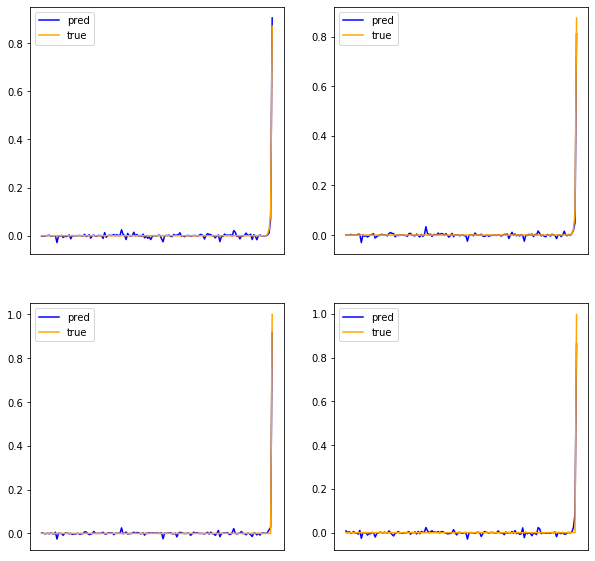

In [65]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = spike_preds[i]
    true = y_test_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Create a seperate mdn model to use on the rest.

In [17]:
model_non_spike = build_mdn_model()

output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_idx]
y = y_train.loc[output_is_not_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
non_spike_fit = model_non_spike.fit(x=X, y=y, batch_size=512, epochs=50, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 128)               20480     
_________________________________________________________________
mdn (MDN)                    (None, 4848)              625392    
Total params: 645,872
Trainable params: 645,872
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
957/957 [==============================] - 17s 18ms/step - loss: -435.5422 - val_loss: -460.6251
Epoch 2/50
957/957 [==============================] - 15s 16ms/step - loss: -466.5030 - val_loss: -459.5728
Epoch 3/50
957/957 [==============================] - 15s 16ms/step - loss: -470.3474 - val_loss: -480.0256
Epoch 4/50
957/957 [==============================] - 

In [21]:
output_is_not_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non_spike = X_test.loc[output_is_not_end_idx]
y_test_non_spike = y_test.loc[output_is_not_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

non_spike_preds = predict_for_test(model_non_spike, X_test_non_spike, y_test_non_spike, 16)

Total time taken: 823.7575925253332. Seconds per prediction: 0.013644244087278186


In [24]:
evaluate_fit(non_spike_preds, y_test_non_spike)

,0
count,60374.000000
mean,968.066454
std,175.587736
min,0.798298
25%,1000.000000
50%,1000.000000
75%,1000.000000
max,1000.000000


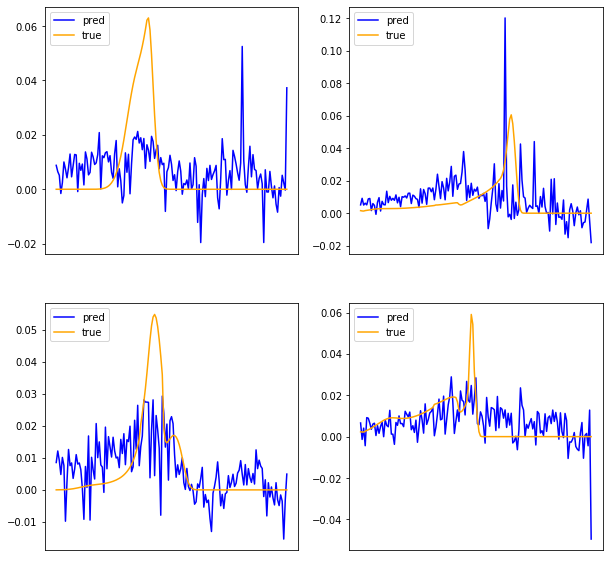

In [27]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = non_spike_preds[i]
    true = y_test_non_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Try to find the best tuning parameters for the neural network. The network gets stuck predicting everything as 0 (75% accuracy), but cannot improve on it.

In [ ]:
#%pip install -U keras-tuner
import kerastuner as kt

def build_model(hp):
        # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    activation = 'selu'

    # Network
    input = tf.keras.Input(shape=(l,))

    layer =  tf.keras.layers.Dense(hp.Int('hidden_size', 16, 256, step=16, default=128), activation=hp.Choice('activation', values=['relu', 'selu', 'tanh', 'swish'], default='relu'), name='baselayer')(input)
    #layer = tf.keras.layers.Dense(1024, activation='relu', name='baselayer')(input)
    #layer_2 = tf.keras.layers.Dense(1024, activation='tanh', name='baselayer2')(layer)
    #layer_3 = tf.keras.layers.Dense(16, activation='tanh', name='baselayer3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(64, activation=activation, name='baselayer4')(layer_3)
    #layer_5 = tf.keras.layers.Dense(32, activation=activation, name='baselayer5')(layer_4)
    # Connect the mdn layer to the output of our neural network
    #mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_5)
    #model = tf.keras.models.Model(input, [mdn_layer])

    # 2 classes
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions")(layer)
    model = tf.keras.models.Model(input, [outputs])


    #opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log'))
    #model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.tuners.BayesianOptimization(
  build_model,
  objective='val_accuracy',
  max_trials=50)

tuner.search(x=X_train, y=y_train, batch_size=128, epochs=30, validation_split=0.1, class_weight=cweights, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [5]:
preds = model.predict(X_test)
display(pd.DataFrame(preds).describe())
display(y_test.describe())

,0
count,40017.000000
mean,0.502865
std,0.064357
min,0.042015
25%,0.452332
50%,0.509930
75%,0.547307
max,0.598693


,Output_Is_End
count,40017.000000
mean,0.243771
std,0.429362
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [93]:
tuner.results_summary()

In [95]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2394/2394 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.78 - ETA: 1s - loss: 0.6925 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accura

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1251/1251 [==============================] - 1s 513us/step - loss: 0.6914 - accuracy: 0.5298
Test accuracy: 0.5297748446464539
